# Introduction to jobflow

In this tutorial, you will:

- Create several jobs.
- Combine the Jobs into a Flow.
- Set up a JobStore - the primary database interface for jobflow.
- Run a Flow using the custom store.
- Examine the Flow outputs.

The purpose of this tutorial is to introduce the main concepts of jobflow. It isn’t intended to demonstrate all the features of jobflow or explain things in great detail.

## Creating job objects

The building block of jobflows are `Job` objects. Jobs are delayed calls to python functions whose outputs are stored in a database. The easiest way to create a job is using the `@job` decorator which be applied to any function, even those with optional parameters.

<div class="alert alert-info">
**Note**
<p>jobflow encodes job outputs as json using the `MontyEncoder` feature of the `monty` package. This means that additional datatypes such as datetime objects, enums, and MSONable classes can also be serialized.</p>
</div>

Lets create a decorated function that times how long it takes to load a website.


In [1]:
import warnings

warnings.filterwarnings("ignore", "Using `tqdm.autonotebook.tqdm`")

In [2]:
from jobflow import job


@job
def time_website(website: str):
    import urllib.request
    from time import perf_counter

    with urllib.request.urlopen(website) as f:
        start_time = perf_counter()
        f.read()
        end_time = perf_counter()

    return end_time - start_time

Any call to the `time_website` function will return a `Job` object rather than executing the function.


In [3]:
time_github = time_website("https://www.github.com")
time_google = time_website("https://www.google.com")
time_nyt = time_website("https://www.nytimes.com")

Jobs have outputs that can be accessed using the `output` attribute. When a job runs, its outputs will be stored in the JobStore. As the job has not yet been executed, the output is currently a reference to the future output.


In [4]:
time_github.output

OutputReference(a317a1e6-0c0e-4a52-9289-dcc9b21752de)

The output of a job can be used as an input to another job. To demonstrate this, let's create a new job function that will sum all its inputs.


In [5]:
@job
def sum_numbers(numbers):
    return sum(numbers)


sum_times = sum_numbers([time_github.output, time_google.output, time_nyt.output])

Note, none of the jobs we have created have been executed. The idea of jobflow is to built up a series of (interconnected) jobs and run them at a later date.


## Creating Flows

A `Flow` is a collection of `Job`s or other `Flow` objects. Flows are the primary tool for defining workflows in jobflow. Let's create a Flow from the jobs we just made:


In [6]:
from jobflow import Flow

flow = Flow([time_github, time_google, time_nyt, sum_times])

The order of the jobs in the input array does not matter. Their execution order will be determined by their connectivity. Because `sum_times` takes the output of `time_github` etc as an input, the timing jobs will always run first.

The connectivity of the jobs in a flow can be visualized:


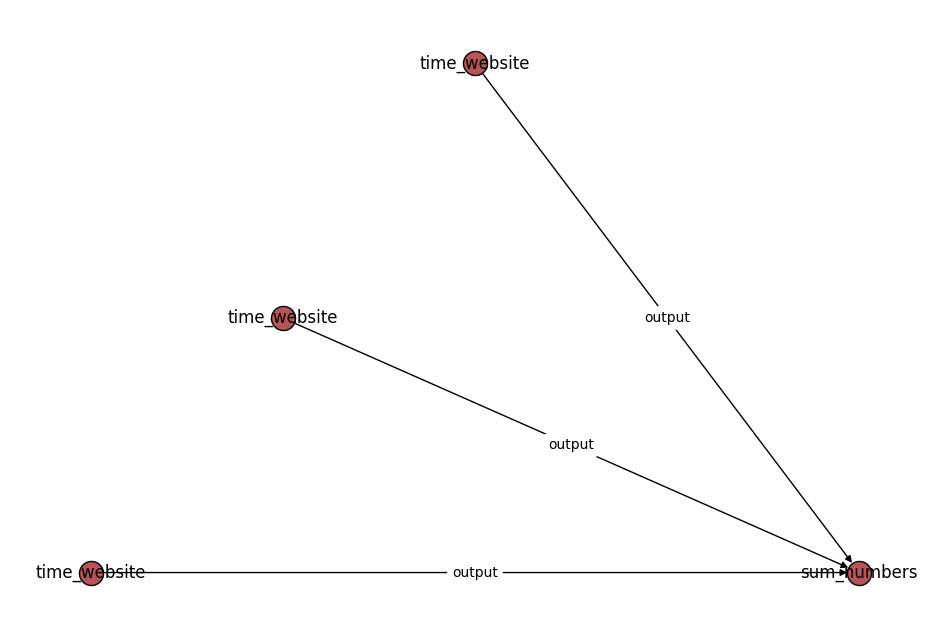

In [7]:
flow.draw_graph().show()

Similar to Jobs, Flows can also have outputs, however, these are not explicitly stored in the database. Instead, the outputs of a Flow act to structure the outputs of the jobs contained within it.

The Flow we just created does not have any outputs. We could instead "register" the output of the sum job as the output of the flow:

```python
flow = Flow(
    jobs=[time_github, time_google, time_nyt, sum_times],
    output=sum_times.output
)
```

This would allow the Flow to be used in the input to a job. For example

```python
new_job = sum_times([flow.output, 10])
```

Note that the Flow output can be structured however you like. For example, you may wish to expose all the job outputs in the form of a dictionary.

```python
flow = Flow(
    jobs=[time_github, time_google, time_nyt, sum_times],
    output={
        "times": [time_github.output, time_google.output, time_nyt.output],
        "sum": sum_times.output
    }
)
```

When can then be used by subsequent jobs as:

```python
new_job = sum_numbers([flow.output["sum"], 10])
```


## Setting up the JobStore

Anything returned by a `Job` will be stored in the `JobStore`, the primary database interface for jobflows.

The `JobStore` is an implementation of the [Store](https://materialsproject.github.io/maggma/reference/stores/) interface provided by the [Maggma package](https://materialsproject.github.io/maggma/reference/stores/). Maggma provides implementations for a number of common databases including:

- MongoDB ([MongoStore](https://materialsproject.github.io/maggma/reference/stores/#maggma.stores.mongolike.MongoStore))
- GridFS ([GridFSStore](https://materialsproject.github.io/maggma/reference/stores/#maggma.stores.gridfs.GridFSStore))
- AWS S3 ([S3Store](https://materialsproject.github.io/maggma/reference/stores/#maggma.stores.aws.S3Store))

Jobflow allows you to store outputs in multiple stores — for example, small documents can be stored in a MongoDB database whereas large files can be stored in an S3 store.

In this example we will use a single store type for all documents. In particular, we will use a special type of store called a `MemoryStore`. This means that any outputs are only stored in memory and not in an external database. For production workflows, we recommend using one of the permanent stores outlined above.

First, we need to create the memory store that will function as the store for all outputs.


In [8]:
from maggma.stores import MemoryStore

docs_store = MemoryStore()

Next we can initialize the JobStore with the memory store.


In [9]:
from jobflow import JobStore

store = JobStore(docs_store)

This type of JobStore (using a MemoryStore for all outputs) is the default store used by jobflow if a custom store is not set.


## Running the Flow

Jobflow supports running Flows locally or on remote clusters. Below we run the Flow locally using the `run_locally` function using our custom store.

<div class="alert alert-info">
**Note**
<p>Running Flows on remote clusters can be achieved using the FireWorks package and is covered in the [ Running Jobflow with FireWorks tutorial](https://materialsproject.github.io/jobflow/tutorials/8-fireworks).</p>
</div>


In [10]:
from jobflow.managers.local import run_locally

responses = run_locally(flow, store=store)

2023-06-07 23:15:00,609 INFO Started executing jobs locally
2023-06-07 23:15:00,619 INFO Starting job - time_website (a317a1e6-0c0e-4a52-9289-dcc9b21752de)
2023-06-07 23:15:01,419 INFO Finished job - time_website (a317a1e6-0c0e-4a52-9289-dcc9b21752de)
2023-06-07 23:15:01,421 INFO Starting job - time_website (5588b25b-009f-4ec8-a7f5-e1a241e18e4c)
2023-06-07 23:15:01,672 INFO Finished job - time_website (5588b25b-009f-4ec8-a7f5-e1a241e18e4c)
2023-06-07 23:15:01,674 INFO Starting job - time_website (6d4e4b9d-7df3-4810-93e7-285b9f3d16b1)
2023-06-07 23:15:02,062 INFO Finished job - time_website (6d4e4b9d-7df3-4810-93e7-285b9f3d16b1)
2023-06-07 23:15:02,065 INFO Starting job - sum_numbers (c4584c1b-cd3d-4f34-be67-5ebe1a48c5e5)
2023-06-07 23:15:02,073 INFO Finished job - sum_numbers (c4584c1b-cd3d-4f34-be67-5ebe1a48c5e5)
2023-06-07 23:15:02,074 INFO Finished executing jobs locally


Below is an annotated example of the log message:

```
2021-06-04 17:36:50,531 INFO Starting job - time_website (d5460743-bb88-4922-8306-0400eb419a91)
                ↑                                 ↑                         ↑
              time                             job name                  job uuid
```

The job uuid is a unique identifier that is assigned to the job when it is created. It is also used to track the job outputs.


## Examine Flow outputs


The `run_locally` function returns the output of all jobs. The format of the output is:

```python
{
    job_uuid: {
        job_index: {
            Response()
        }
    }
}
```

The `job_index` and `Response()` objects are introduced in later tutorials. The main thing to know is that the Response contains the output of the Job and any other commands for controlling the Flow execution.


In [11]:
responses

{'a317a1e6-0c0e-4a52-9289-dcc9b21752de': {1: Response(output=0.23619829999999986, detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False)},
 '5588b25b-009f-4ec8-a7f5-e1a241e18e4c': {1: Response(output=0.034831500000000126, detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False)},
 '6d4e4b9d-7df3-4810-93e7-285b9f3d16b1': {1: Response(output=0.14804260000000014, detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False)},
 'c4584c1b-cd3d-4f34-be67-5ebe1a48c5e5': {1: Response(output=0.4190724000000001, detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False)}}

We can check the output of specific jobs using:


In [12]:
responses[time_github.uuid][1].output

0.23619829999999986

In general, it is easier to examine the outputs a job using the `JobStore.get_output` function. This will query the database (in this case the `MemoryStore`) and return the output of the job. If using multiple stores, the relevant outputs will be automatically queried from the appropriate stores.

Let's query the database for the output of the `time_github` job.


In [13]:
store.get_output(time_github.uuid)

0.23619829999999986

## Next steps

Now that you are more familiar jobflows, we encourage you to learn about all the different options jobflow provides for designing and running workflows. A good next step is the [Defining Jobs using jobflow tutorial](https://hackingmaterials.lbl.gov/jobflow/tutorials/3-defining-jobs.html), which will cover the `Job` object and `job` decorator in more detail.
